In [240]:
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import GetAssetsRequest
from alpaca.trading.enums import AssetClass, AssetStatus

from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest, StockQuotesRequest, StockLatestQuoteRequest
from alpaca.data.timeframe import TimeFrame

from datetime import datetime
import pandas as pd


def volatility_calculator(df): 
    prev_close = df['close'].shift(1)
    return (abs(df['close'] - prev_close) / df['close']).dropna()

def filter_by_regular_hours(data, datetime_column):
    return data[(pd.to_datetime(data[datetime_column]).dt.time >= pd.to_datetime("15:30:00").time()) & \
                (pd.to_datetime(data[datetime_column]).dt.time <=  pd.to_datetime("20:00:00").time()) & \
                (pd.to_datetime(data[datetime_column]).dt.dayofweek < 5)].reset_index(drop=True)


class StockDataRetriever:
    API_KEY = "PKGG13YXB1TNOXBQC6UU"
    API_SECRET = "DOrUyg0g639FRkLhNrKzQKVilmGvzg3PZCpyFpeK"

    def __init__(self, timeframe=TimeFrame.Minute):
        self.timeframe = timeframe
        self.client = StockHistoricalDataClient(self.API_KEY,  self.API_SECRET)

    def get_all_symbols(self): 
        trading_client = TradingClient(self.API_KEY, self.API_SECRET)
        search_params = GetAssetsRequest(asset_class=AssetClass.US_EQUITY)

        assets = trading_client.get_all_assets(search_params)
        assets = [asset for asset in assets if \
                asset.status == AssetStatus.ACTIVE and 
                asset.easy_to_borrow and 
                asset.fractionable and 
                not asset.min_order_size and 
                asset.shortable and
                asset.tradable]
        return [asset.symbol for asset in assets]

    def bars(self, 
             symbol_or_symbols, 
             start=datetime(2025, 5, 1),
             end=datetime(2025, 5, 2),):
        request_params = StockBarsRequest(
            symbol_or_symbols=symbol_or_symbols,
            timeframe=self.timeframe,
            start=start,
            end=end,
            feed='sip'
        )
        bars = self.client.get_stock_bars(request_params).data
        return {symbol: 
                pd.DataFrame([data_item.__dict__ 
                 for data_item in stock_data])\
                  .drop(columns=['symbol', 'trade_count'])\
                   .rename(columns={'timestamp': 'date'})
                    for symbol, stock_data in bars.items()}
    
    def todays_bars(self, symbol_or_symbols, limit=100): 
        request_params = StockBarsRequest(
            symbol_or_symbols=symbol_or_symbols,
            timeframe=self.timeframe,
            feed='sip'
        )
        bars = self.client.get_stock_bars(request_params).data
        return {symbol: 
                pd.DataFrame([data_item.__dict__ 
                 for data_item in stock_data]).head(limit)
                  .drop(columns=['symbol', 'trade_count'])\
                   .rename(columns={'timestamp': 'date'})
                    for symbol, stock_data in bars.items()}
    
    def todays_volatility(self, symbol_or_symbols, limit=100): 
        todays_bars = self.todays_bars(symbol_or_symbols, limit)
        return {symbol: volatility_calculator(symbol_data).median()
                for symbol, symbol_data in todays_bars.items()}
    
    def quote(self, 
             symbol_or_symbols, 
             start=datetime(2025, 5, 1),
             end=datetime(2025, 5, 2),):
        # todo 
        # request_params = StockQuotesRequest(
        #     symbol_or_symbols=[symbol],
        #     # timeframe=self.timeframe,
        #     start=self.start,
        #     end=self.end,
        #     feed='sip',
        #     limit=1
        # )
        # quotes = client.get_stock_quotes(request_params)
        pass 
        
    def latest_quote(self, symbol_or_symbols): 
        request_params = StockLatestQuoteRequest(
            symbol_or_symbols=symbol_or_symbols,
            feed='sip',
        )
        quotes = self.client.get_stock_latest_quote(request_params)

        return quotes
    
    def latest_spread(self, symbol_or_symbols): 
        quotes = self.latest_quote(symbol_or_symbols)
        return {symbol: (quote.ask_price - quote.bid_price) / quote.bid_price 
                for symbol, quote in quotes.items()}

In [242]:
retriever = StockDataRetriever()
all_symbols = retriever.get_all_symbols()

In [245]:
todays_bars = retriever.todays_bars(all_symbols)
todays_volatilities = {symbol: volatility_calculator(symbol_data).median()
    for symbol, symbol_data in todays_bars.items()}

In [246]:
quotes = retriever.latest_quote(all_symbols)
latest_spreads =  {symbol: (quote.ask_price - quote.bid_price) / quote.bid_price 
                    for symbol, quote in quotes.items()}

In [315]:
minimal_spreads = {symbol: 0.01 / quote.bid_price 
                    for symbol, quote in quotes.items()}

In [267]:
LIQUIDITY_TARGET = 10000
liquid_symbols = [symbol for symbol in all_symbols 
                  if symbol in latest_spreads 
                  and symbol in todays_bars
                  and quotes[symbol].bid_price * min(quotes[symbol].bid_size, quotes[symbol].ask_size) * 100 >= LIQUIDITY_TARGET]
len(liquid_symbols)

1640

In [269]:
volatility_to_spread = {symbol: todays_volatilities[symbol] / latest_spreads[symbol] 
                        for symbol in liquid_symbols}

In [316]:
volatility_to_minimal_spread = {symbol: todays_volatilities[symbol] / minimal_spreads[symbol] 
                        for symbol in liquid_symbols}

In [270]:
dict(sorted(volatility_to_spread.items(), key=lambda item: - item[1])[:10])

{'MU': np.float64(6.040677966097403),
 'DAL': np.float64(5.980422014358607),
 'RSP': np.float64(5.521333372224203),
 'APH': np.float64(5.273492852709252),
 'AMD': np.float64(5.114097363080257),
 'GOOG': np.float64(5.070850817965725),
 'GOOGL': np.float64(5.063236738709096),
 'QQQ': np.float64(5.030631188107373),
 'IGV': np.float64(5.026627813501966),
 'VTI': np.float64(4.767893513083875)}

In [318]:
dict(sorted(volatility_to_minimal_spread.items(), key=lambda item: - item[1])[:10])

{'NVR': np.float64(941.2881443054981),
 'GHC': np.float64(773.7826197004936),
 'BKNG': np.float64(612.2961148327196),
 'WTM': np.float64(338.03613658303465),
 'FICO': np.float64(323.32039272894286),
 'COKE': np.float64(320.6642543704502),
 'MELI': np.float64(262.30125570967704),
 'TPL': np.float64(224.71462097564307),
 'ALX': np.float64(223.56356056668764),
 'WINA': np.float64(219.24657921074956)}

In [355]:
symbol = 'GHC'

spread = minimal_spreads[symbol]
vol = todays_volatilities[symbol]
print(f'TopBookVolume: {quotes[symbol].bid_price * min(quotes[symbol].bid_size, quotes[symbol].ask_size) * 100}')
spread, vol

TopBookVolume: 94306.0


(1.0603779186902213e-05, np.float64(0.008205020037966764))

In [364]:
from random import random 


acc = 0.53
start_capital = 1

for _ in range(20 * 1): 
    for _ in range(350): 
        if random() < acc: 
            start_capital *= (1 + vol - spread)
        else: 
            start_capital *= (1 - vol - spread)

start_capital

np.float64(53.1593487041284)

In [65]:
class Vol: 
    def __init__(self,
                 period,
                 close_feature='close'):
        self.period = period
        self.close_feature = close_feature

    def __call__(self, df): 
        prev_close = df[self.close_feature].shift(1)
        vol = abs(df[self.close_feature] - prev_close)
        return vol.ewm(span=self.period, adjust=False).mean().fillna(0)

In [233]:
stock_df

,open,high,low,close,volume,date
0,209.5800,209.8600,209.3600,209.36,3814.0,2025-05-01 08:00:00+00:00
1,209.1700,209.4500,209.1700,209.40,2499.0,2025-05-01 08:01:00+00:00
2,209.4500,209.4600,209.4000,209.40,2165.0,2025-05-01 08:02:00+00:00
3,209.4000,209.4000,209.2500,209.25,2794.0,2025-05-01 08:03:00+00:00
4,209.1400,209.1400,209.1400,209.14,1311.0,2025-05-01 08:04:00+00:00
...,...,...,...,...,...,...
252,209.3500,209.3500,209.1700,209.24,13424.0,2025-05-01 12:58:00+00:00
253,209.2000,209.2000,209.1100,209.13,5888.0,2025-05-01 12:59:00+00:00
254,209.1100,209.1800,209.0500,209.11,9219.0,2025-05-01 13:00:00+00:00
255,209.1106,209.1300,209.1106,209.13,1205.0,2025-05-01 13:01:00+00:00


In [235]:
vol = Vol(10)
vol(stock_df).iloc[-1]

np.float64(0.05496075017553037)

In [66]:
import numpy as np

class ATR:
    def __init__(self,
                 period,
                 high_feature='high',
                 low_feature='low',
                 close_feature='close'):
        self.period = period
        self.high_feature = high_feature
        self.low_feature = low_feature
        self.close_feature = close_feature

    def __call__(self, df):
        # Calculate the True Range (TR)
        prev_close = df[self.close_feature].shift(1)

        temp_df = pd.DataFrame()
        temp_df['high-low'] = df[self.high_feature] - df[self.low_feature]
        temp_df['high-Previous close'] = np.abs(df[self.high_feature] - prev_close)
        temp_df['low-Previous close'] = np.abs(df[self.low_feature] - prev_close)

        tr = temp_df[['high-low', 'high-Previous close', 'low-Previous close']].max(axis=1)

        # Calculate the ATR using an Exponential Moving Average (EMA)
        return tr.ewm(span=self.period, adjust=False).mean()
    

vol = Vol(10)
atr_values = vol(result[result['date'] > '2025-01-06 14:29:00+00:00'][result['date'] <= '2025-01-06 21:00:00+00:00'])

C:\Users\ikurnosau\AppData\Local\Temp\ipykernel_30944\541701687.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  atr_values = vol(result[result['date'] > '2025-01-06 14:29:00+00:00'][result['date'] <= '2025-01-06 21:00:00+00:00'])


In [67]:
atr_values

1394    0.000000
1395    0.605000
1396    0.570455
1397    0.721281
1398    0.668321
          ...   
1780    0.179625
1781    0.181512
1782    0.186691
1783    0.243657
1784    0.210264
Name: close, Length: 391, dtype: float64

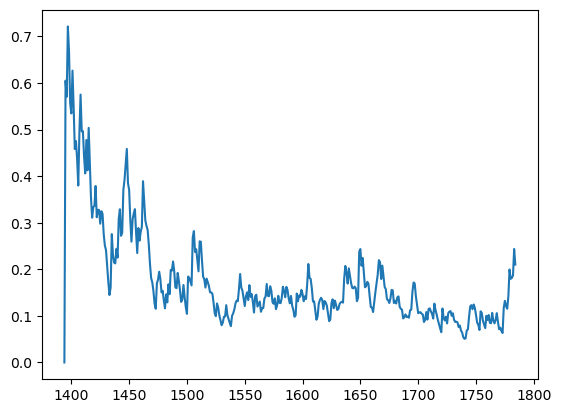

In [68]:
import matplotlib.pyplot as plt

plt.plot(atr_values)

In [69]:
atr_values.mean()

np.float64(0.17714759605404895)

In [71]:

from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockQuotesRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime

class StockQuoteRetriever:
    API_KEY = "PKGG13YXB1TNOXBQC6UU"
    API_SECRET = "DOrUyg0g639FRkLhNrKzQKVilmGvzg3PZCpyFpeK"

    def __init__(self,
            start='2025-01-02 16:28:00+00:00',
            end='2025-01-02 16:29:00+00:00',
            timeframe=TimeFrame.Minute):
        self.start = start
        self.end = end
        self.timeframe = timeframe

    def __call__(self, symbol):
        client = StockHistoricalDataClient(self.API_KEY,  self.API_SECRET)

        request_params = StockQuotesRequest(
            symbol_or_symbols=[symbol],
            # timeframe=self.timeframe,
            start=self.start,
            end=self.end,
            feed='sip',
            limit=1
        )
        quotes = client.get_stock_quotes(request_params).df
        quotes[TSLDatasetConstants.DATETIME_COLUMN_NAME] = [cur_index[1] for cur_index in quotes.index]

        return quotes.reset_index(drop=True)

In [139]:
quotes_retriever = StockQuoteRetriever()
quotes_retriever('APO')

,bid_price,bid_size,bid_exchange,ask_price,ask_size,ask_exchange,conditions,tape,date
0,164.72,4.0,N,164.9,1.0,T,[R],A,2025-01-02 16:28:01.641019+00:00


In [140]:
95.03 * 100 * 1

9503.0

In [141]:
stocks = [
    'AMD', 'AES', 'ABNB', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'APH', 'ADI', 'APA',
    'APO', 'AAPL', 'APTV', 'ADM', 'ANET', 'T', 'BKR', 'BALL', 'BAC', 'BX', 'BA',
    'BSX', 'BMY', 'AVGO', 'CPB', 'CCL', 'CARR', 'CNC', 'CNP', 'SCHW', 'CVX', 'CMG',
    'CSCO', 'CFG', 'KO', 'CL', 'CMCSA', 'COP', 'CEG', 'CSX', 'CVS', 'DHR', 'DECK',
    'DELL', 'DAL', 'DVN', 'D', 'DOW', 'EBAY', 'EIX', 'EA', 'ENPH', 'EQT', 'EQR',
    'EL', 'XOM', 'FITB', 'F', 'FTNT', 'FOXA', 'BEN', 'GE', 'GEN', 'GIS', 'GM',
    'GILD', 'HAL', 'DOC', 'HPE', 'HST', 'HPQ', 'HBAN', 'IBM', 'INTC', 'JNJ', 'JPM',
    'KDP', 'KEY', 'KMI', 'KKR', 'KHC', 'KR', 'LRCX', 'LEN', 'MPC', 'MTCH', 'MDT',
    'META', 'MET', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MNST', 'NDAQ', 'NFLX',
    'NEM', 'NEE', 'NKE', 'NCLH', 'NVDA', 'OXY', 'ON', 'OKE', 'PLTR', 'PANW', 'PYPL',
    'PEP', 'PFE', 'PCG', 'PM', 'PPL', 'PG', 'QCOM', 'O', 'CRM', 'SLB', 'LUV',
    'SBUX', 'SMCI', 'SYF', 'SYY', 'TGT', 'TSLA', 'TXN', 'TJX', 'TSCO', 'USB',
    'UBER', 'UAL', 'VZ', 'VTRS', 'V', 'VST', 'WBA', 'WMT', 'DIS', 'WBD', 'WDC', 'WMB'
]

spreads = []
quotes = []
for stock in stocks: 
    quote = quotes_retriever(stock)
    quotes.append(quote)
    
    spread = quote['ask_price'] - quote['bid_price']
    spreads.append(spread)


In [142]:
spreads = [spread.iloc[0] for spread in spreads]

In [143]:
spreads

[np.float64(0.030000000000001137),
 np.float64(0.009999999999999787),
 np.float64(0.09999999999999432),
 np.float64(0.03999999999999204),
 np.float64(0.03999999999999204),
 np.float64(0.010000000000005116),
 np.float64(0.040000000000020464),
 np.float64(0.009999999999999787),
 np.float64(0.09000000000000341),
 np.float64(0.29999999999998295),
 np.float64(0.00999999999999801),
 np.float64(0.18000000000000682),
 np.float64(0.03999999999999204),
 np.float64(0.03999999999999915),
 np.float64(0.030000000000001137),
 np.float64(0.20000000000000284),
 np.float64(0.00999999999999801),
 np.float64(0.00999999999999801),
 np.float64(0.020000000000003126),
 np.float64(0.00999999999999801),
 np.float64(0.2599999999999909),
 np.float64(0.08999999999997499),
 np.float64(0.06999999999999318),
 np.float64(0.00999999999999801),
 np.float64(0.08999999999997499),
 np.float64(0.02999999999999403),
 np.float64(0.00999999999999801),
 np.float64(0.020000000000010232),
 np.float64(0.03999999999999915),
 np.flo

In [144]:
spreads_filtered = [spread for spread in spreads if spread < 0.03]

<Axes: >

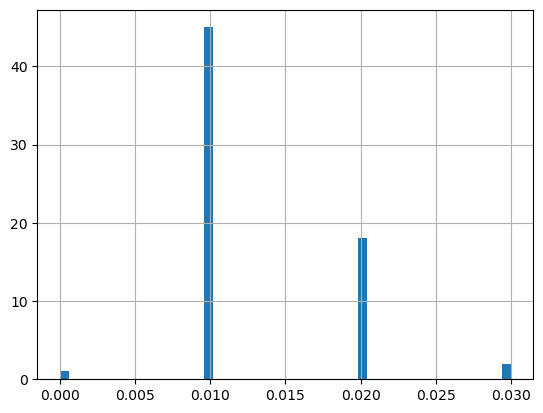

In [145]:
pd.Series(spreads_filtered).hist(bins=50)

In [237]:
0.02 / 161

0.00012422360248447205

In [155]:
low_spread_quotes = [quote for quote in quotes if (quote['ask_price'] - quote['bid_price']).iloc[0] <= 0.03]

<Axes: >

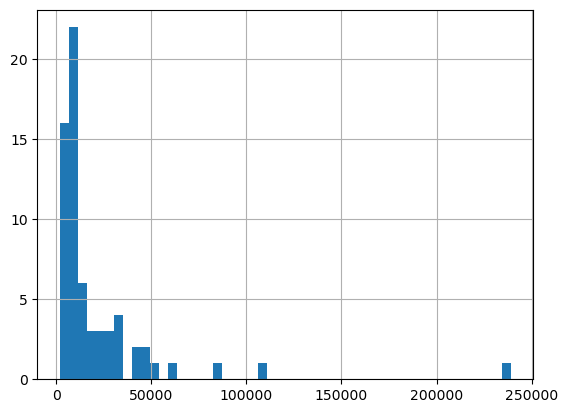

In [157]:
volumes = [quote['bid_price'].iloc[0] * min(quote['bid_size'].iloc[0], quote['ask_size'].iloc[0]) * 100 for quote in low_spread_quotes]
pd.Series(volumes).hist(bins=50)

In [158]:
sorted(volumes)

[np.float64(2042.0000000000002),
 np.float64(3076.0),
 np.float64(3263.0000000000005),
 np.float64(4426.0),
 np.float64(5034.0),
 np.float64(5204.0),
 np.float64(5214.0),
 np.float64(5290.0),
 np.float64(5504.0),
 np.float64(5602.0),
 np.float64(5713.0),
 np.float64(5921.0),
 np.float64(6042.0),
 np.float64(6198.0),
 np.float64(6316.0),
 np.float64(6362.0),
 np.float64(6872.0),
 np.float64(6884.999999999999),
 np.float64(7769.0),
 np.float64(7808.0),
 np.float64(8015.000000000001),
 np.float64(8334.0),
 np.float64(8376.0),
 np.float64(8652.0),
 np.float64(8679.0),
 np.float64(9258.0),
 np.float64(9576.0),
 np.float64(9592.0),
 np.float64(9690.0),
 np.float64(9719.999999999998),
 np.float64(10085.999999999998),
 np.float64(10540.0),
 np.float64(10546.0),
 np.float64(10690.0),
 np.float64(10776.0),
 np.float64(10868.0),
 np.float64(11256.0),
 np.float64(11398.0),
 np.float64(11800.0),
 np.float64(13326.0),
 np.float64(13786.000000000002),
 np.float64(13944.0),
 np.float64(15096.0),
 np.f

In [84]:
len(spreads_filtered)

66

In [41]:
(2 * acc - 1) * vol - spread

5.9999999999999954e-05

In [245]:
(1 + 2.26e-5) ** (390 * 20 * 6)

2.8796479537661503

In [186]:
start_capital

13038.742677098666

In [125]:
from alpaca.data.live import StockDataStream

API_KEY = "PKGG13YXB1TNOXBQC6UU"
API_SECRET = "DOrUyg0g639FRkLhNrKzQKVilmGvzg3PZCpyFpeK"

wss_client = StockDataStream(API_KEY, API_SECRET)

# async handler
async def quote_data_handler(data):
    # quote data will arrive here
    print(data)

wss_client.subscribe_quotes(quote_data_handler, "AAPL")

In [126]:
wss_client.run()

AttributeError: 'NoneType' object has no attribute 'is_running'